# NCAA College Baseball Win Probability Model

Created by Avery Wang

Goal: Create an in-game win probability model for college baseball. This will form the bedrock of in-game strategy analysis. Specifically, we want to answer the question: at the beginning of a given at bat, what is each team’s probability of winning the game?

## 1. Introduction
### 1.1 Background
The basic idea behind win probability modeling in baseball is to create a model that predicts who will win at the end of each half-inning. We can then use a run expectancy table (gives the respective probability of each number of runs scored in the rest of the inning) to get the distribution of end-of-half-inning states from the current at-bat.

For example, say it’s the bottom of the 7th inning, the home team is winning by 1 run and has a runner on 1st with 2 outs. We can build a model that tells us the following:
- when the home team is winning by 1 run at the end of the 7th inning, they win 80% of the time
- when the home team is winning by 2 runs at the end of the 7th inning, they win 90% of the time
- when the home team is winning by 3 runs at the end of the 7th inning, they win 95% of the time

Given the current base-out state (whether there is a baserunner on 1st, 2nd, 3rd, and the number of outs - there is a runner on 1st with 2 outs), we get the following information from our run-expectancy table:
- the probability of scoring 0 runs in the rest of the inning is 60%
- the probability of scoring 1 run in the rest of the inning is 25%
- the probability of scoring 2 runs in the rest of the inning is 15%

So, we can obtain a win probability as follows:
(0.6 chance of winning by 1 run at end of inning) * (0.8 chance of winning if winning by 1 run at end of inning) + (0.25 chance of winning by 2 runs at end of inning) * (0.9 chance of winning if winning by 2 runs at end of inning) + (0.15 chance of winning by 3 runs at end of inning) * (0.95 chance of winning if winning by 3 runs at end of inning) = 84.75%

Therefore, the home team has about an 85% chance of winning at this point.

Previously, we already modeled a run expectancy table, so the main task is modeling win probability at the end of each half inning (see the following table). The most important predictor of win probability is score differential (how many runs is one team ahead of the other team). We will then explore other predictors to improve the model.

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 0)
run_expectancy = pd.read_csv('run_expectancy_table.csv')
run_expectancy

,base_1_occupied_pre,base_2_occupied_pre,base_3_occupied_pre,outs_in_inning_so_far_before_event,0,1,2,3,4,5,run_exp
0,False,False,False,0,0.694649,0.160238,0.075960,0.037348,0.017294,0.014510,0.565932
1,True,False,False,0,0.584801,0.200027,0.108036,0.056751,0.027155,0.023229,0.811120
2,False,True,False,0,0.521501,0.216880,0.127368,0.070083,0.034350,0.029818,0.968355
3,False,False,True,0,0.468239,0.226909,0.143826,0.082797,0.041582,0.036646,1.112513
4,True,True,False,0,0.402905,0.233117,0.163683,0.100589,0.052413,0.047293,1.308367
...,...,...,...,...,...,...,...,...,...,...,...
19,False,False,True,2,0.771010,0.126102,0.055093,0.026082,0.011863,0.009850,0.411237
20,True,True,False,2,0.720684,0.149136,0.068705,0.033327,0.015332,0.012816,0.511933
21,True,False,True,2,0.675812,0.167900,0.081297,0.040385,0.018793,0.015814,0.605891
22,False,True,True,2,0.617307,0.189540,0.098317,0.050560,0.023934,0.020343,0.735303


### 1.2 Scope of Work
THe main task is building 18 models to predict game winner at the end of each half inning. Many features might matter for predicting game winner, but the most important is score differential. First, we want to build models based on score differential to get an initial answer.

We also want to investigate potential weaknesses of our model, specifically questions about the run environment. The run environment reflects the number of runs scored in a game: in a high-scoring league, losing by 1 run is less of a big deal than losing by 1 run in a low-scoring league.
- Does league matter? Do some conferences have higher-scoring games than others? (Perhaps due to the style of the teams in the conference, the size of the ballparks, etc)
- Do pitchers matter? In college baseball, teams typically throw their best pitchers on Friday, second best on Saturday, third best on Sunday, and fourth best on Tuesday. Are run environments lower on Friday than on Saturday, Sunday, and Tuesday?

A note on overfitting: if you ask a coach what their probability of winning the game is, they’ll probably cite lots of factors that are specific to their team (their pitcher is pitching well, they have a well-rested bullpen, they have a deep bench of pinch-hitters, etc). While these factors may well affect game win probability, we will not be able to pick up on these effects in the small sample sizes that we have. Also, coaches tend to overestimate the importance of these effects. As a result, we won’t really incorporate team-specific information into our models.


## 2. Data Preparation
We will be using play-by-play data from 6 conferences. There may be overlap between these files (intra-conference games). Games are uniquely identified by the “game_info_url” column. Other important columns include 
- inning (inning number)
- inning_top_bot (top if top of inning, bot if bottom of inning)
- score (away team listed first, home team listed second)
- batting (the team that is batting in the current half-inning)
- fielding (the team that is fielding in the current half-inning). 

In [2]:
import numpy as np
df = pd.read_csv('pac12_2013_2018.csv', parse_dates=['date']) # Stanford is in pac 12
df

,date,location,attendance,inning,inning_top_bot,score,batting,fielding,description,game_info_url
0,2013-02-15,"Tucson, Ariz.",5145.0,1,top,0-0,Coppin St.,Arizona,KASHANGAKI grounded out to 1b unassisted (0-2 SK).,https://stats.ncaa.org/game/index/1639012?org_id=29
1,2013-02-15,"Tucson, Ariz.",5145.0,1,top,0-0,Coppin St.,Arizona,WRIGHT struck out swinging (1-2 KSBS).,https://stats.ncaa.org/game/index/1639012?org_id=29
2,2013-02-15,"Tucson, Ariz.",5145.0,1,top,0-0,Coppin St.,Arizona,HAMLETT struck out swinging (2-2 BBKFS).,https://stats.ncaa.org/game/index/1639012?org_id=29
3,2013-02-15,"Tucson, Ariz.",5145.0,1,bot,0-0,Arizona,Coppin St.,"Kingery, S. lined out to 2b (2-2 KFBB).",https://stats.ncaa.org/game/index/1639012?org_id=29
4,2013-02-15,"Tucson, Ariz.",5145.0,1,bot,0-0,Arizona,Coppin St.,"Maggi, J. walked (3-1 BBBKB).",https://stats.ncaa.org/game/index/1639012?org_id=29
...,...,...,...,...,...,...,...,...,...,...
262292,2018-05-15,"Pullman, Wash.",672.0,13,bot,3-2,Washington St.,Gonzaga,"Smith, J singled through the right side (3-2 FKFBBB).",https://stats.ncaa.org/game/index/4582603?org_id=754
262293,2018-05-15,"Pullman, Wash.",672.0,13,bot,3-2,Washington St.,Gonzaga,"Waterman, C out at first p to 2b, SAC, bunt (0-1 F)3a Smith, J advanced to second.",https://stats.ncaa.org/game/index/4582603?org_id=754
262294,2018-05-15,"Pullman, Wash.",672.0,13,bot,3-2,Washington St.,Gonzaga,"Plew, D walked (3-2 BFFBBFB).",https://stats.ncaa.org/game/index/4582603?org_id=754
262295,2018-05-15,"Pullman, Wash.",672.0,13,bot,3-2,Washington St.,Gonzaga,"Alvarez, A flied out to rf (0-0).",https://stats.ncaa.org/game/index/4582603?org_id=754


### 2.1 Identifying the home and away team
For consistency, we will calculate score differentials from the perspective of the home team, so a positive score differential means the home team is ahead. To figure out which is the home team, we can simply check who is the batting team at the bottom of an inning.

In [3]:
df['home_team'] = np.where(df['inning_top_bot'] == 'bot', df['batting'], df['fielding'])
df['away_team'] = np.where(df['inning_top_bot'] == 'top', df['batting'], df['fielding'])
df = df.drop(['location', 'attendance', 'batting', 'fielding', 'description'], axis=1) # unimportant columns
df

,date,inning,inning_top_bot,score,game_info_url,home_team,away_team
0,2013-02-15,1,top,0-0,https://stats.ncaa.org/game/index/1639012?org_id=29,Arizona,Coppin St.
1,2013-02-15,1,top,0-0,https://stats.ncaa.org/game/index/1639012?org_id=29,Arizona,Coppin St.
2,2013-02-15,1,top,0-0,https://stats.ncaa.org/game/index/1639012?org_id=29,Arizona,Coppin St.
3,2013-02-15,1,bot,0-0,https://stats.ncaa.org/game/index/1639012?org_id=29,Arizona,Coppin St.
4,2013-02-15,1,bot,0-0,https://stats.ncaa.org/game/index/1639012?org_id=29,Arizona,Coppin St.
...,...,...,...,...,...,...,...
262292,2018-05-15,13,bot,3-2,https://stats.ncaa.org/game/index/4582603?org_id=754,Washington St.,Gonzaga
262293,2018-05-15,13,bot,3-2,https://stats.ncaa.org/game/index/4582603?org_id=754,Washington St.,Gonzaga
262294,2018-05-15,13,bot,3-2,https://stats.ncaa.org/game/index/4582603?org_id=754,Washington St.,Gonzaga
262295,2018-05-15,13,bot,3-2,https://stats.ncaa.org/game/index/4582603?org_id=754,Washington St.,Gonzaga


### 2.2 Parsing the score to find the score differential
Next, we parse the string that represents the score, taking the number before the dash as the away score and the number after the dash as the home score. From this we can calculate the score differential (useful for modeling) and runs scored (useful for visualization of run environment). 

In [4]:
df[['away_score', 'home_score']] = df['score'].str.split('-', expand=True)
df['home_score'] = pd.to_numeric(df['home_score'], downcast='integer')
df['away_score'] = pd.to_numeric(df['away_score'], downcast='integer')
df['score_differential'] = df['home_score'] - df['away_score']
df['runs_scored'] = df['home_score'] + df['away_score']
df = df.drop(['score', 'away_score', 'home_score'], axis=1)
df = df.sort_values(['game_info_url', 'inning', 'inning_top_bot', 'runs_scored'], ascending=[True, True, False, True])
df

,date,inning,inning_top_bot,game_info_url,home_team,away_team,score_differential,runs_scored
5294,2013-02-15,1,top,https://stats.ncaa.org/game/index/1638993?org_id=28,Arizona St.,Bethune-Cookman,0,0
5295,2013-02-15,1,top,https://stats.ncaa.org/game/index/1638993?org_id=28,Arizona St.,Bethune-Cookman,0,0
5296,2013-02-15,1,top,https://stats.ncaa.org/game/index/1638993?org_id=28,Arizona St.,Bethune-Cookman,0,0
5297,2013-02-15,1,top,https://stats.ncaa.org/game/index/1638993?org_id=28,Arizona St.,Bethune-Cookman,0,0
5298,2013-02-15,1,bot,https://stats.ncaa.org/game/index/1638993?org_id=28,Arizona St.,Bethune-Cookman,0,0
...,...,...,...,...,...,...,...,...
242990,2018-06-28,8,bot,https://stats.ncaa.org/game/index/4587494?org_id=528,Oregon St.,Arkansas,5,5
242991,2018-06-28,8,bot,https://stats.ncaa.org/game/index/4587494?org_id=528,Oregon St.,Arkansas,5,5
242992,2018-06-28,9,top,https://stats.ncaa.org/game/index/4587494?org_id=528,Oregon St.,Arkansas,5,5
242993,2018-06-28,9,top,https://stats.ncaa.org/game/index/4587494?org_id=528,Oregon St.,Arkansas,5,5


### 2.3 Tabulating end-game results
Later, we will need to use the current score differential at each inning to predict the end result. Here, we create a table of the end results of each game. Each game is uniquely identified by a game_info_url, so we use the groupby operation to do so. Note that it is very important we sort the table in the previous cell, because our groupby operation will take the last row of each game, which is the end of the game. Since there might be a change in score in the last inning, we keep the row with the highest runs scored.

In [5]:
game_results = df.groupby('game_info_url').last()
game_results['home_won'] = game_results['score_differential'] > 0 # warning, we will need to deal with tied games!

game_results['game_winner'] = np.where(game_results['home_won'], game_results['home_team'], game_results['away_team'])
game_results = game_results.drop(labels=['date', 'home_team', 'away_team'], axis=1)
game_results

,inning,inning_top_bot,score_differential,runs_scored,home_won,game_winner
game_info_url,,,,,,
https://stats.ncaa.org/game/index/1638993?org_id=28,11,bot,1,9,True,Arizona St.
https://stats.ncaa.org/game/index/1639012?org_id=29,9,top,16,16,True,Arizona
https://stats.ncaa.org/game/index/1639013?org_id=108,9,top,4,12,True,UC Davis
https://stats.ncaa.org/game/index/1639112?org_id=277,9,bot,-3,3,False,Oregon
https://stats.ncaa.org/game/index/1639192?org_id=370,9,bot,-3,9,False,Utah
...,...,...,...,...,...,...
https://stats.ncaa.org/game/index/4587314?org_id=528,9,top,10,14,True,Oregon St.
https://stats.ncaa.org/game/index/4587354?org_id=430,9,bot,-3,7,False,Oregon St.
https://stats.ncaa.org/game/index/4587454?org_id=528,9,bot,-3,5,False,Arkansas


### 2.4 Tabulating inning-by-inning results
We want inning-by-inning data, since we want to be able to predict whether the home team wins at the end of each inning given the score differential. We take the original table, but this time we group by the half-inning instead.

In [6]:
df_inning = df.groupby(by=['game_info_url', 'inning', 'inning_top_bot']).last().reset_index()
df_inning

,game_info_url,inning,inning_top_bot,date,home_team,away_team,score_differential,runs_scored
0,https://stats.ncaa.org/game/index/1638993?org_id=28,1,bot,2013-02-15,Arizona St.,Bethune-Cookman,0,0
1,https://stats.ncaa.org/game/index/1638993?org_id=28,1,top,2013-02-15,Arizona St.,Bethune-Cookman,0,0
2,https://stats.ncaa.org/game/index/1638993?org_id=28,2,bot,2013-02-15,Arizona St.,Bethune-Cookman,0,0
3,https://stats.ncaa.org/game/index/1638993?org_id=28,2,top,2013-02-15,Arizona St.,Bethune-Cookman,0,0
4,https://stats.ncaa.org/game/index/1638993?org_id=28,3,bot,2013-02-15,Arizona St.,Bethune-Cookman,1,1
...,...,...,...,...,...,...,...,...
48518,https://stats.ncaa.org/game/index/4587494?org_id=528,7,bot,2018-06-28,Oregon St.,Arkansas,4,4
48519,https://stats.ncaa.org/game/index/4587494?org_id=528,7,top,2018-06-28,Oregon St.,Arkansas,4,4
48520,https://stats.ncaa.org/game/index/4587494?org_id=528,8,bot,2018-06-28,Oregon St.,Arkansas,5,5
48521,https://stats.ncaa.org/game/index/4587494?org_id=528,8,top,2018-06-28,Oregon St.,Arkansas,4,4


### 2.5 Joining the inning-by-inning data with the final game results
Our predictors are the score differential at each half-inning. Our response variable is the final game result. They are on separate tables, so let us join these tables. In pandas, this is the right merge operation.

At the end of this operation, each row in our table corresponds to the end of a half inning of a game. Also included in each row of the table are the final inning, inning_top_bot, and score_differential at the end of that game.


In [7]:
df_inning_result = df_inning.merge(right=game_results, on='game_info_url', suffixes=['', '_result'])
df_inning_result

,game_info_url,inning,inning_top_bot,date,home_team,away_team,score_differential,runs_scored,inning_result,inning_top_bot_result,score_differential_result,runs_scored_result,home_won,game_winner
0,https://stats.ncaa.org/game/index/1638993?org_id=28,1,bot,2013-02-15,Arizona St.,Bethune-Cookman,0,0,11,bot,1,9,True,Arizona St.
1,https://stats.ncaa.org/game/index/1638993?org_id=28,1,top,2013-02-15,Arizona St.,Bethune-Cookman,0,0,11,bot,1,9,True,Arizona St.
2,https://stats.ncaa.org/game/index/1638993?org_id=28,2,bot,2013-02-15,Arizona St.,Bethune-Cookman,0,0,11,bot,1,9,True,Arizona St.
3,https://stats.ncaa.org/game/index/1638993?org_id=28,2,top,2013-02-15,Arizona St.,Bethune-Cookman,0,0,11,bot,1,9,True,Arizona St.
4,https://stats.ncaa.org/game/index/1638993?org_id=28,3,bot,2013-02-15,Arizona St.,Bethune-Cookman,1,1,11,bot,1,9,True,Arizona St.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48518,https://stats.ncaa.org/game/index/4587494?org_id=528,7,bot,2018-06-28,Oregon St.,Arkansas,4,4,9,top,5,5,True,Oregon St.
48519,https://stats.ncaa.org/game/index/4587494?org_id=528,7,top,2018-06-28,Oregon St.,Arkansas,4,4,9,top,5,5,True,Oregon St.
48520,https://stats.ncaa.org/game/index/4587494?org_id=528,8,bot,2018-06-28,Oregon St.,Arkansas,5,5,9,top,5,5,True,Oregon St.
48521,https://stats.ncaa.org/game/index/4587494?org_id=528,8,top,2018-06-28,Oregon St.,Arkansas,4,4,9,top,5,5,True,Oregon St.


### 2.6 Adding columns for day of the week and conference
There are some last house-keeping items, which is to create the day_of_week and attach the conference name

In [8]:
df_inning_result['day_of_week'] = pd.DatetimeIndex(df_inning_result['date']).day_name()
df_inning_result['conference'] = 'pac12'
df_inning_result = df_inning_result.drop(['day_of_week'], axis=1)
df_inning_result

,game_info_url,inning,inning_top_bot,date,home_team,away_team,score_differential,runs_scored,inning_result,inning_top_bot_result,score_differential_result,runs_scored_result,home_won,game_winner,conference
0,https://stats.ncaa.org/game/index/1638993?org_id=28,1,bot,2013-02-15,Arizona St.,Bethune-Cookman,0,0,11,bot,1,9,True,Arizona St.,pac12
1,https://stats.ncaa.org/game/index/1638993?org_id=28,1,top,2013-02-15,Arizona St.,Bethune-Cookman,0,0,11,bot,1,9,True,Arizona St.,pac12
2,https://stats.ncaa.org/game/index/1638993?org_id=28,2,bot,2013-02-15,Arizona St.,Bethune-Cookman,0,0,11,bot,1,9,True,Arizona St.,pac12
3,https://stats.ncaa.org/game/index/1638993?org_id=28,2,top,2013-02-15,Arizona St.,Bethune-Cookman,0,0,11,bot,1,9,True,Arizona St.,pac12
4,https://stats.ncaa.org/game/index/1638993?org_id=28,3,bot,2013-02-15,Arizona St.,Bethune-Cookman,1,1,11,bot,1,9,True,Arizona St.,pac12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48518,https://stats.ncaa.org/game/index/4587494?org_id=528,7,bot,2018-06-28,Oregon St.,Arkansas,4,4,9,top,5,5,True,Oregon St.,pac12
48519,https://stats.ncaa.org/game/index/4587494?org_id=528,7,top,2018-06-28,Oregon St.,Arkansas,4,4,9,top,5,5,True,Oregon St.,pac12
48520,https://stats.ncaa.org/game/index/4587494?org_id=528,8,bot,2018-06-28,Oregon St.,Arkansas,5,5,9,top,5,5,True,Oregon St.,pac12
48521,https://stats.ncaa.org/game/index/4587494?org_id=528,8,top,2018-06-28,Oregon St.,Arkansas,4,4,9,top,5,5,True,Oregon St.,pac12


### 2.7 Repeating process for all 6 conferences
We created a table of half-innings and their results for the PAC 12 conference. Let's do the same for all other conferences, and combine them into a single table.

In [9]:
# The same six steps above
def parse_conference_play_by_play_data(conference_name):
    df = pd.read_csv(conference_name + '_2013_2018.csv', parse_dates=['date'])

    df['home_team'] = np.where(df['inning_top_bot'] == 'bot', df['batting'], df['fielding'])
    df['away_team'] = np.where(df['inning_top_bot'] == 'top', df['batting'], df['fielding'])
    df = df.drop(['location', 'attendance', 'batting', 'fielding', 'description'], axis=1) # unimportant columns

    df[['away_score', 'home_score']] = df['score'].str.split('-', expand=True)
    df['home_score'] = pd.to_numeric(df['home_score'], downcast='integer')
    df['away_score'] = pd.to_numeric(df['away_score'], downcast='integer')
    df['score_differential'] = df['home_score'] - df['away_score']
    df['runs_scored'] = df['home_score'] + df['away_score']
    df = df.drop(['score', 'away_score', 'home_score'], axis=1)
    df = df.sort_values(['game_info_url', 'inning', 'inning_top_bot', 'runs_scored'], ascending=[True, True, False, True])

    game_results = df.groupby('game_info_url').last()
    game_results['home_won'] = game_results['score_differential'] > 0 # warning, we will need to deal with tied games!
    game_results['game_winner'] = np.where(game_results['home_won'], game_results['home_team'], game_results['away_team'])
    game_results = game_results.drop(labels=['date', 'home_team', 'away_team'], axis=1)

    df_inning = df.groupby(by=['game_info_url', 'inning', 'inning_top_bot']).last().reset_index()
    
    df_inning_result = df_inning.merge(right=game_results, on='game_info_url', suffixes=['', '_result']).reset_index()

    df_inning_result['day_of_week'] = pd.DatetimeIndex(df_inning_result['date']).day_name()
    df_inning_result['conference'] = conference_name
    df_inning_result.drop(['date'], axis=1)
    print(conference_name, len(df_inning_result.index))
    return df_inning_result

In [10]:
conference_list = ['acc', 'american', 'big10', 'big12', 'pac12', 'sec']
df_list = [parse_conference_play_by_play_data(c) for c in conference_list]
df_concat_inning_result = pd.concat(df_list)
df_concat_inning_result

acc 62776
american 42812
big10 55888
big12 43763
pac12 48523
sec 66376


,index,game_info_url,inning,inning_top_bot,date,home_team,away_team,score_differential,runs_scored,inning_result,inning_top_bot_result,score_differential_result,runs_scored_result,home_won,game_winner,day_of_week,conference
0,0,https://stats.ncaa.org/game/index/1637276?org_id=235,1,bot,2013-02-15,Florida,Duke,0,0,9,bot,-1,7,False,Duke,Friday,acc
1,1,https://stats.ncaa.org/game/index/1637276?org_id=235,1,top,2013-02-15,Florida,Duke,0,0,9,bot,-1,7,False,Duke,Friday,acc
2,2,https://stats.ncaa.org/game/index/1637276?org_id=235,2,bot,2013-02-15,Florida,Duke,1,1,9,bot,-1,7,False,Duke,Friday,acc
3,3,https://stats.ncaa.org/game/index/1637276?org_id=235,2,top,2013-02-15,Florida,Duke,0,0,9,bot,-1,7,False,Duke,Friday,acc
4,4,https://stats.ncaa.org/game/index/1637276?org_id=235,3,bot,2013-02-15,Florida,Duke,1,1,9,bot,-1,7,False,Duke,Friday,acc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66371,66371,https://stats.ncaa.org/game/index/4587494?org_id=528,7,bot,2018-06-28,Oregon St.,Arkansas,4,4,9,top,5,5,True,Oregon St.,Thursday,sec
66372,66372,https://stats.ncaa.org/game/index/4587494?org_id=528,7,top,2018-06-28,Oregon St.,Arkansas,4,4,9,top,5,5,True,Oregon St.,Thursday,sec
66373,66373,https://stats.ncaa.org/game/index/4587494?org_id=528,8,bot,2018-06-28,Oregon St.,Arkansas,5,5,9,top,5,5,True,Oregon St.,Thursday,sec
66374,66374,https://stats.ncaa.org/game/index/4587494?org_id=528,8,top,2018-06-28,Oregon St.,Arkansas,4,4,9,top,5,5,True,Oregon St.,Thursday,sec


We add a column x_plot, that simply maps the top of the innings to the inning number, and the bottom of the innings to the inning number + 0.5. This will make it easier to plot quantities across half-innings later.

In [11]:
df_concat_inning_result['x_plot'] = df_concat_inning_result['inning'] + np.where(df_concat_inning_result['inning_top_bot'] == 'top', 0, 0.5)


### 2.8 Summary
We've created a table that has a separate entry for each (game_id, inning, top/bot) tuple. Each entry contains the score differential and total runs scored at the end of that half-inning, and also the final winner of that game. This will allow us to efficiently filter for the score differential at various half-innings.

# 3. Data Exploration

We will now explore this dataset, consider potential features to use in the modeling process, and fix any inconsistencies we find in the dataset.

### 3.1 Duplicate Games

Inter-conference games may appear in two different conference files. When we combined all 6 conference files, the data from both games are added to our table. We will remove these duplicate games by removing any duplicate rows with the same game_info_url, inning, and inning_top_bot. Before we do so, since we will later be examining the run environment of each conference, will record these inter-column games by adding a column (named 'conference_all') which indicates which 1 or 2 conferences this game belongs to. 

Code-wise, we are grouping all rows with the same game_info_url, inning, and inning_top_bot, adding all the values inside 'conference' into a set (so duplicates are removed), joining it into a string, and placing the result in 'conference_all'.  

In [12]:
df_conference_merged = df_concat_inning_result['conference'].groupby(
    [df_concat_inning_result.game_info_url,
     df_concat_inning_result.inning,
     df_concat_inning_result.inning_top_bot
    ]
).apply(set).apply(lambda x: '/'.join(x)).reset_index()
df_concat_inning_result = df_concat_inning_result.merge(right=df_conference_merged, \
                                                        on=['game_info_url', 'inning', 'inning_top_bot'], \
                                                        suffixes=['', '_all']).reset_index()
df_concat_inning_result = df_concat_inning_result.groupby(['game_info_url', 'inning', 'inning_top_bot']).first()
df_concat_inning_result = df_concat_inning_result.drop(['level_0', 'index', 'conference'], axis=1).reset_index()
df_concat_inning_result.sort_values(by=['conference_all', 'game_info_url', 'inning', 'inning_top_bot'], \
                                   ascending=[False, True, True, False]) # so we can see examples of duplicates

,game_info_url,inning,inning_top_bot,date,home_team,away_team,score_differential,runs_scored,inning_result,inning_top_bot_result,score_differential_result,runs_scored_result,home_won,game_winner,day_of_week,x_plot,conference_all
3816,https://stats.ncaa.org/game/index/1700492?org_id=694,1,top,2013-02-22,Tennessee,Arizona St.,0,0,9,bot,-4,4,False,Arizona St.,Friday,1.0,sec/pac12
3815,https://stats.ncaa.org/game/index/1700492?org_id=694,1,bot,2013-02-22,Tennessee,Arizona St.,0,0,9,bot,-4,4,False,Arizona St.,Friday,1.5,sec/pac12
3818,https://stats.ncaa.org/game/index/1700492?org_id=694,2,top,2013-02-22,Tennessee,Arizona St.,-1,1,9,bot,-4,4,False,Arizona St.,Friday,2.0,sec/pac12
3817,https://stats.ncaa.org/game/index/1700492?org_id=694,2,bot,2013-02-22,Tennessee,Arizona St.,-1,1,9,bot,-4,4,False,Arizona St.,Friday,2.5,sec/pac12
3820,https://stats.ncaa.org/game/index/1700492?org_id=694,3,top,2013-02-22,Tennessee,Arizona St.,-1,1,9,bot,-4,4,False,Arizona St.,Friday,3.0,sec/pac12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293530,https://stats.ncaa.org/game/index/4586595?org_id=457,7,bot,2018-06-09,Stetson,North Carolina,-3,11,9,bot,-2,12,False,North Carolina,Saturday,7.5,acc
293533,https://stats.ncaa.org/game/index/4586595?org_id=457,8,top,2018-06-09,Stetson,North Carolina,-3,11,9,bot,-2,12,False,North Carolina,Saturday,8.0,acc
293532,https://stats.ncaa.org/game/index/4586595?org_id=457,8,bot,2018-06-09,Stetson,North Carolina,-3,11,9,bot,-2,12,False,North Carolina,Saturday,8.5,acc
293535,https://stats.ncaa.org/game/index/4586595?org_id=457,9,top,2018-06-09,Stetson,North Carolina,-3,11,9,bot,-2,12,False,North Carolina,Saturday,9.0,acc


### 3.2 Creating Master File
At this step, we write the table we have to a master file. This file may be useful for future projects, so we save it here. In addition, the previous few steps were computationally intensive, so if we need to recreate the previous tables, we can simply read from the master file.

In [13]:
df_concat_inning_result.to_csv(path_or_buf='master_2013_2018.csv', header=True, index=False)
df_concat_inning_result = pd.read_csv('master_2013_2018.csv')

### 3.3 Incomplete Games

Most games end in 9 innings. Some games that are tied after 9 innings go into extra-innings, and these games are very important to model even for the first 9 innings, so that our model takes into account not only the probability of winning in 9 innings, but also the probability of winning in extra-innings if the game is tied after 9 innings. 

However, games that end in fewer than 9 innings pose a problem.
- A good number of games end in 7 innings when the game is part of a double-header, as dictated by mutual agreement or conference rules. 
- The umpire is allowed to call a game after 5 innings due to various reasons (for example, weather).

In [14]:
from tabulate import tabulate

df_games = df_concat_inning_result.groupby('game_info_url').last().reset_index()
inning_dist = df_games['inning_result'].value_counts(normalize=False, sort=True)
print(tabulate(sorted(inning_dist.items()), headers=['total innings', 'games']))

  total innings    games
---------------  -------
              1        1
              5       11
              6       16
              7      228
              8       71
              9    15036
             10      570
             11      306
             12      162
             13       94
             14       40
             15       29
             16       12
             17        5
             18        9
             19        1
             20        1
             22        1


Since the models are implicitly using the number of innings to determine how many opportunities the team behind have to score, we cannot accurately use games that end early in our model, so we will simply discard these.

In [15]:
df_concat_inning_result = df_concat_inning_result[df_concat_inning_result['inning_result'] >= 9]

### 3.4 Tied Games

Some games in the dataset end up tied. We can't incorporate these into our model, because our response variable is binary: whether the home team won or lost. We will discard tied games.

In [16]:
df_games = df_concat_inning_result.groupby('game_info_url').last().reset_index()
df_games[df_games['score_differential_result'] == 0]

,game_info_url,inning,inning_top_bot,date,home_team,away_team,score_differential,runs_scored,inning_result,inning_top_bot_result,score_differential_result,runs_scored_result,home_won,game_winner,day_of_week,x_plot,conference_all
852,https://stats.ncaa.org/game/index/1890629?org_id=127,9,top,2013-03-13,Central Conn. St.,UConn,0,0,9,bot,0,0,False,UConn,Wednesday,9.0,american
1538,https://stats.ncaa.org/game/index/2038206?org_id=817,9,top,2013-04-09,Youngstown St.,Pittsburgh,0,0,9,bot,0,0,False,Pittsburgh,Tuesday,9.0,american
2059,https://stats.ncaa.org/game/index/2136293?org_id=572,9,top,2013-04-30,Rhode Island,Boston College,0,0,9,bot,0,0,False,Boston College,Tuesday,9.0,acc
2066,https://stats.ncaa.org/game/index/2136733?org_id=534,9,top,2013-04-30,Pacific,California,0,0,9,bot,0,0,False,California,Tuesday,9.0,pac12
2368,https://stats.ncaa.org/game/index/2192513?org_id=813,9,top,2013-04-03,Yale,UConn,0,0,9,top,0,0,False,UConn,Wednesday,9.0,american
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16187,https://stats.ncaa.org/game/index/4586114?org_id=428,10,top,2018-06-02,UCLA,Minnesota,0,0,10,bot,0,0,False,Minnesota,Saturday,10.0,pac12/big10
16192,https://stats.ncaa.org/game/index/4586120?org_id=490,9,top,2018-06-03,Army West Point,NC State,0,0,9,bot,0,0,False,NC State,Sunday,9.0,acc
16193,https://stats.ncaa.org/game/index/4586121?org_id=521,9,top,2018-06-03,Oklahoma St.,South Fla.,0,0,9,top,0,0,False,South Fla.,Sunday,9.0,american/big12
16200,https://stats.ncaa.org/game/index/4586133?org_id=31,9,top,2018-06-03,Arkansas,DBU,0,0,9,top,0,0,False,DBU,Sunday,9.0,sec


In [17]:
df_concat_inning_result = df_concat_inning_result[df_concat_inning_result['score_differential_result'] != 0]

### 3.5 Time Evolution of Score Differential and Impact on Home Win
The most important feature is score differential, since it is the score differential at the end of the game that determines whether the home team wins. The higher the score differential, the more likely the home team will maintain that lead until the end of the game. We can see that with the following scatterplot.

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True, context='talk')

f, ax1 = plt.subplots(1, 1, figsize=(25, 7))
sns.despine(left=False)

reg = df_concat_inning_result[(df_concat_inning_result['inning'] <= 9)]

p = sns.color_palette("coolwarm_r", 2)

sns.violinplot(x='x_plot', y='score_differential', hue='home_won', \
               split=True, scale='width', inner='quart', kind='violin', \
               cut=0, data=reg, palette=p, ax=ax1)
ax1.set_xlabel('inning (.0 = end of top, .5 = end of bot)')
ax1.legend(loc='upper left')
plt.tight_layout()

We make the following observations:
- Games in which the home team wins are centered with a positive score differential, while games in which the home team loses are centered with a negative score differential. This conforms to our prior knowledge on how baseball works!
- The difference in centers between the blue and red distributions increases later in the game. We should expect later innings to be easier to model because the distributions are more easily separable.
- In the bottom of the top of first inning, there are no score differentials that are greater than zero. In the bottom of the end of the ninth inning, the blue distributions have score differentials that are mostly 0 and 1. The games at 0 represent the games going into extra innings, and the scores at 1 represent the walk-off wins. Non-walk-off wins would have ended in the top of the ninth inning.

### 3.5 Summary Statistics for Conference and Day of Week
We can also look into two features: the conference and the day of the week the games are played in. Different conferences may different team styles, different ballparks, and even minor differences in rules (such as the previously described rule of calling doubleheaders in 7 innings). The day of the week in college baseball can serve as a proxy for the strength of the pitcher. Coaches usually have their strongest starting pitchers pitch on Friday, followed by Saturday, Sunday, and their lastly on Tuesday. Games are rarely held on other days, except in the case of delays.

In [19]:
df_conference = df_concat_inning_result
df_conference['conference'] = np.where(df_conference['conference_all'].str.find('/') == -1, \
                                       df_conference['conference_all'], 'inter')
df_inter = df_concat_inning_result[df_concat_inning_result['conference_all'].str.find('/') != -1]

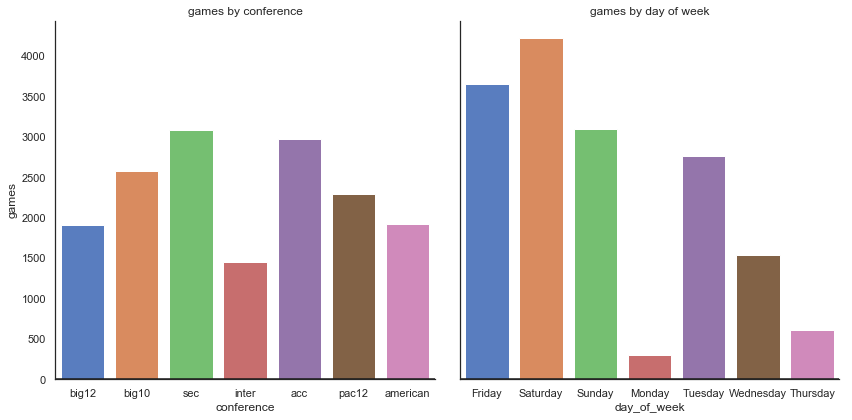

In [20]:
sns.set(style="white", palette="muted", color_codes=True, context='notebook')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=True)

# Generate some sequential data
sns.countplot(x='conference', data=df_conference.groupby('game_info_url').last(), ax=ax1)
ax1.axhline(0, color="k", clip_on=True)
ax1.set_ylabel("games")
ax1.set_title("games by conference")

# Center the data to make it diverging
sns.countplot(x='day_of_week', data=df_conference.groupby('game_info_url').last(), ax=ax2)
ax2.axhline(0, color="k", clip_on=True)
ax2.set_ylabel("games")
ax2.set_title("games by day of week")
ax2.set_ylabel("")


sns.despine(bottom=False)
plt.tight_layout(h_pad=2)

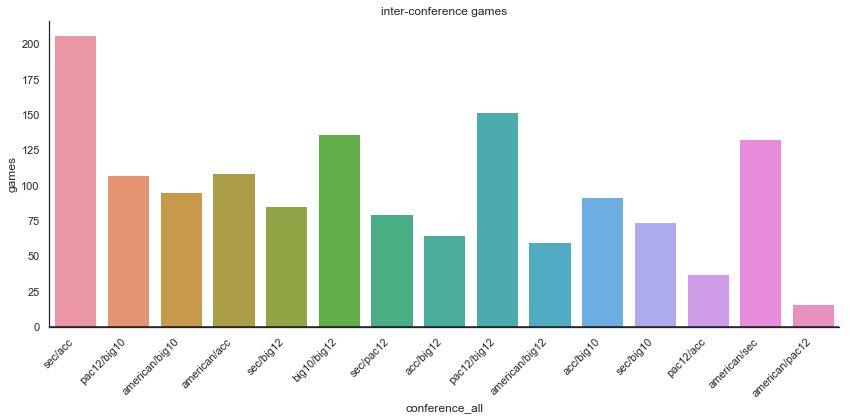

In [21]:
sns.set(style="white", palette="muted", color_codes=True, context='notebook')

f, (ax1) = plt.subplots(1, 1, figsize=(12, 6), sharex=False, sharey=True)

sns.countplot(x='conference_all', data=df_inter.groupby('game_info_url').last(), ax=ax1)
ax1.axhline(0, color="k", clip_on=True)
ax1.set_ylabel("games")
ax1.set_title("inter-conference games")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')

sns.despine(bottom=False)
plt.tight_layout(h_pad=2)

We make the following observations:
- The six conferences have around 2000-3000 games played over 6 years. The number of games roughly corresponds to the number of teams in each conference currently (e.g. american has 11 main teams, sec has 14)
- There are a significant number of inter-conference games, enough that we may need to model them separately. While there are some pairings which are surprisingly unequal in frequency (acc/sec, big12/pac12 are much more common than other pairings), the number of games for each pairing is fairly small (less than 200), so we will avoid splitting down the intra-conference games into smaller groups.
- As expected, most games happen on Friday, Saturday, Sunday, and Tuesday. There are a significant number of Wednesday and Thursday games. As we'll see later, there is evidence that suggests that Thursday games were rescheduled Friday games, and Wednesday games are rescheduled Tuesday games. This would mean all four playing days have roughly the same number of games.

### 3.6 Home Field Advantage by Conference and Day of Week
Now that we have visualized the distribution of games by conference and day of week, let's see how these features are related to whether or not the home team wins. It's well-known that the home team wins more often. In Major League Baseball, the home team wins around 53% of the time. We can quantify this advantage here across different conference and days of weeks. If the difference between conferences and days of the week are signficant, it may make sense to incorporate conferences and days of week into the win probability model.

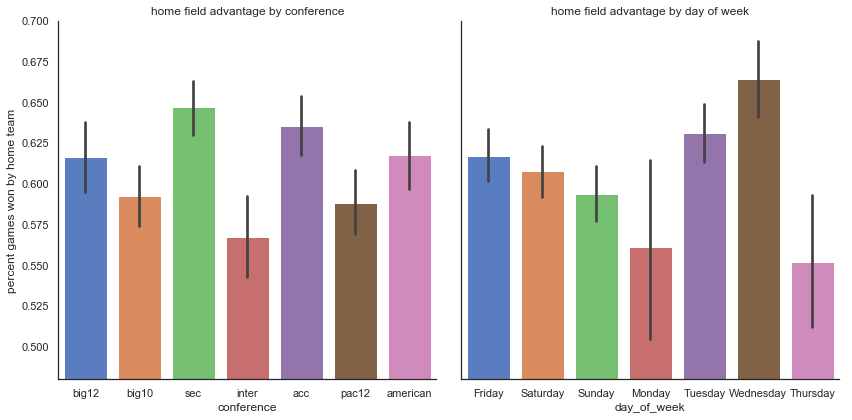

In [42]:
sns.set(style="white", palette="muted", color_codes=True, context='notebook')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=True)

# Generate some sequential data
sns.barplot(x='conference', y='home_won', data=df_conference.groupby('game_info_url').last(), ax=ax1)
ax1.axhline(0, color="k", clip_on=True)
ax1.set_ylabel("percent games won by home team")
ax1.set_title("home field advantage by conference")

sns.barplot(x='day_of_week' , \
            y='home_won', ax=ax2, data = df_conference.groupby('game_info_url').last())
ax2.axhline(0, color="k", clip_on=True)
ax2.set_title("home field advantage by day of week")
ax2.set_ylim(0.48, 0.7)
ax2.set_ylabel("")


sns.despine(bottom=False)
plt.tight_layout(h_pad=2)

We make the following observations
- Home field advantage is much stronger in college baseball compared to the MLB. Among all games, the home team wins 61.4% of the time. When we model the win probabilities, we should not be surprised that the home field probabilities seem high, especially at the beginning of the game.
- Among conferences, there is a possible difference in home field advantage. The pac12 and big10 conferences have a smaller home field advantage, almost 5% difference in wins, compared to sec and acc conferences. In particular, inter-conference games seem to offer the least home field advantage, perhaps because the modifications in rules to accomodate different conferences impact the away team less. We would expect away team travel, one of the biggest cause of home field advantage, to be a greater concern for inter-conference leagues, so perhaps there are rules that help teams which have to travel for conferences (e.g. extra rest day).
- Among the most important days of the week, there is not a significant difference in home field advantage. 

### 3.7 Analysis of Run Environment
The run environment reflects the number of runs scored in a game: in a high-scoring league, losing by 1 run is less of a big deal than losing by 1 run in a low-scoring league.

#### 3.7.1 Plotting Mean and Bootstrapped Confidence Interval
First, we explore the run environment by simply plotting the mean for each conference and day of week.

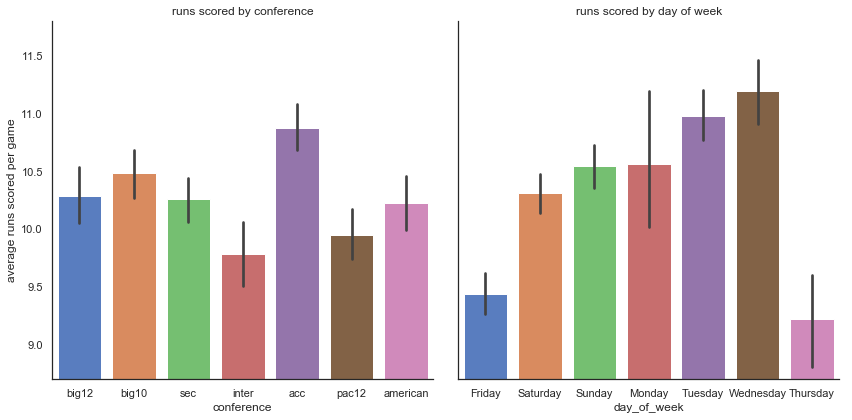

In [23]:
sns.set(style="white", palette="muted", color_codes=True, context='notebook')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=True)

sns.barplot(x='conference', y='runs_scored_result', data=df_conference.groupby('game_info_url').last(), ax=ax1)
ax1.axhline(0, color="k", clip_on=True)
ax1.set_ylabel("average runs scored per game")
ax1.set_title("runs scored by conference")

sns.barplot(x='day_of_week', y='runs_scored_result', data=df_conference.groupby('game_info_url').last(), ax=ax2)
ax2.axhline(0, color="k", clip_on=True)
ax2.set_title("runs scored by day of week")
ax2.set_ylabel("")
ax2.set_ylim(8.7, 11.8)

sns.despine(bottom=False)
plt.tight_layout(h_pad=2)

We making the following observations:
- Most conferences have similar run enviornments, with the exception of acc and inter-conference games. 
- Significantly fewer runs are scored on Fridays compared to the other important days of the week. This confirms our belief that the day of the week serves as a proxy for pitcher strength, since the strongest pitchers are usually scheduled to pitch on Friday.
- While there does not seem to be enough data points to confirm this conclusion, there is a possibility that Tuesday and Wednesday games are very similar in terms of pitcher strength (possibly Wednesday games are rescheduled games previously on a Tuesday), and similarly for Thursday and Friday games.

#### 3.7.2 Distribution of run environment
We can go a step further and create histograms of the run distribution to visualize any differences in the run environment among conferences and days of the week.

In [24]:
df_games = df_conference.groupby('game_info_url').last()

df_results_total_runs_by_day = {}
df_results_total_runs_by_conference = {}
df_results_score_differential_by_day = {}
df_results_score_differential_by_conference = {}
days_of_week = ['Friday', "Saturday", 'Sunday', 'Tuesday', 'Wednesday', 'Thursday', 'Monday', 'all']
conference_names = ['big12', 'big10', 'sec', 'acc', 'pac12', 'american', 'inter', 'all']
color_names = ['blue', 'green', 'red', 'orange', 'purple', 'indigo', 'brown']
for day in days_of_week[:-1]:
    df_results_total_runs_by_day[day] = df_games[df_games['day_of_week'] == day]['runs_scored_result']
    df_results_score_differential_by_day[day] = df_games[df_games['day_of_week'] == day]['score_differential_result']
df_results_total_runs_by_day['all'] = df_games['runs_scored_result']
df_results_score_differential_by_day['all'] = df_games['score_differential_result']

for conference in conference_names[:-1]:
    df_results_total_runs_by_conference[conference] = df_games[df_games['conference'] == conference]['runs_scored_result']
    df_results_score_differential_by_conference[conference] = df_games[df_games['conference'] == conference]['score_differential_result']
df_results_total_runs_by_conference['all'] = df_games['runs_scored_result']
df_results_score_differential_by_conference['all'] = df_games['score_differential_result']



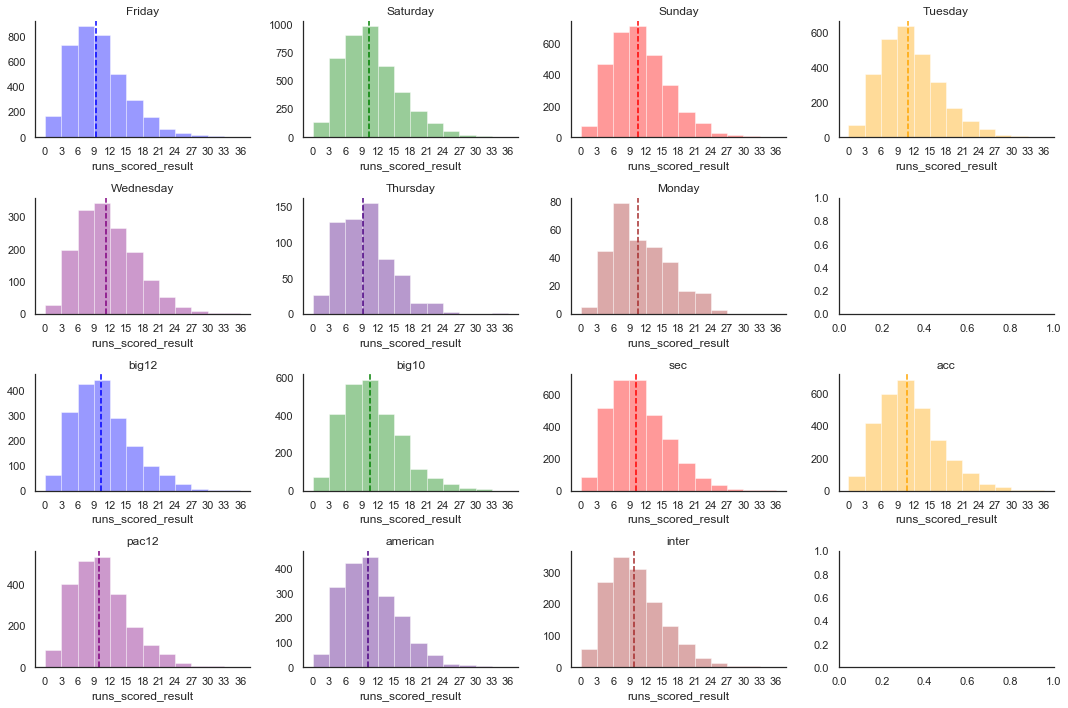

In [25]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(4, 4, figsize=(15, 10), sharex=False, sharey=False)
sns.despine(left=False)

arr = np.arange(0, 39, 3)
for day, color, idx in zip(days_of_week, color_names, range(len(color_names))):
    sns.distplot(df_results_total_runs_by_day[day], bins=arr, kde=False, color=color, ax=axes[idx//4, idx%4], norm_hist=False)
    axes[idx//4, idx%4].set_title(day)
    mean = np.mean(df_results_total_runs_by_day[day])
    axes[idx//4, idx%4].axvline(mean, linestyle='--', color=color)
    axes[idx//4, idx%4].set_xticks(arr)


for conference, color, idx in zip(conference_names, color_names, range(len(color_names))):
    sns.distplot(df_results_total_runs_by_conference[conference], bins=arr, kde=False, color=color, ax=axes[2+idx//4, idx%4], norm_hist=False)
    axes[2+idx//4, idx%4].set_title(conference)
    mean = np.mean(df_results_total_runs_by_conference[conference])
    axes[2+idx//4, idx%4].axvline(mean, linestyle='--', color=color)
    axes[2+idx//4, idx%4].set_xticks(arr)
    
plt.tight_layout()

We can make the following observations:
- The shape of all distributions with sufficient data (everything except Wednesday/Thursday/Monday) look similar.
- The key difference is the distribution for Friday is centered significantly lower compared to the other distributions for days of week.
- The acc conference has a higher proportion of mid to high scoring games (9-15 runs) compared to the other conferences, which is resulting in its higher mean.
- Intra-conference games have lower runs scored, especially in the 6-9 run region.

#### 3.7.3 ANOVA for difference in means
To confirm these observations, we can run statistical tests for difference in means to compare the various conference and days of week groups.

In [26]:
import scipy.stats as stats
pairwise_tests_conf = [[None for i in range(8)] for j in range(7)]

for i, conf_1 in zip(range(7), conference_names[:-1]):
    pairwise_tests_conf[i][0] = conf_1
    for j, conf_2 in zip(range(i+1), conference_names[:-1]):
        tstat, pval = stats.ttest_ind(list(df_results_total_runs_by_conference[conf_1]), \
                                      list(df_results_total_runs_by_conference[conf_2]))
        pairwise_tests_conf[i][j+1] = pval
        
pairwise_tests_day = [[None for i in range(8)] for j in range(7)]

for i, conf_1 in zip(range(7), days_of_week[:-1]):
    pairwise_tests_day[i][0] = conf_1
    for j, conf_2 in zip(range(i+1), days_of_week[:-1]):
        tstat, pval = stats.ttest_ind(list(df_results_total_runs_by_day[conf_1]), \
                                      list(df_results_total_runs_by_day[conf_2]))
        pairwise_tests_day[i][j+1] = pval

In [27]:
print(tabulate(pairwise_tests_conf, headers=[''] + conference_names[:-1]))
print()
print(tabulate(pairwise_tests_day, headers=[''] + days_of_week[:-1]))

                big12        big10          sec          acc      pac12    american    inter
--------  -----------  -----------  -----------  -----------  ---------  ----------  -------
big12     1
big10     0.231916     1
sec       0.841549     0.112781     1
acc       0.000263426  0.00800693   8.92636e-06  1
pac12     0.0403015    0.000519556  0.0347672    8.81513e-10  1
american  0.703713     0.106471     0.822121     4.15241e-05  0.0941361   1
inter     0.00759596   9.03314e-05  0.00555265   6.49233e-10  0.363629    0.0186484        1

                Friday     Saturday       Sunday      Tuesday    Wednesday    Thursday    Monday
---------  -----------  -----------  -----------  -----------  -----------  ----------  --------
Friday     1
Saturday   5.22253e-13  1
Sunday     6.28208e-18  0.0661563    1
Tuesday    2.41281e-30  5.24303e-07  0.00188474   1
Wednesday  3.11453e-27  7.26476e-08  0.000120331  0.235667      1
Thursday   0.332885     3.34141e-06  1.27423e-08  4.07742e-13   

The differences between the means of the following groups and other groups are statistically significant, and are a promising area to look into when improving the model:
- Friday
- Tuesday
- intra-conference games
- acc conference

### 3.8 Summary
We've cleared showed that score differential in combination with the current half-inning is most powerful in predicting whether the home team wins. We will use this approach first. We've found that run environments are potentially different among days of the week (Friday/Tuesday) and the conference (acc, intra-conference). We can either model the groups separately since we have sufficient data for these groups, or we can attempt to normalize the score differential based on the run environment.

## 4. Modeling

We want to create 18 models, one for each half-inning, where we predict game winner from score differential. Just for kicks, we will also create models for the later half-innings, although there are serious modeling problems that we will need to address later if we want to create win probability models for extra-innings.


### 4.1 Model Selection

We will model win probability using a logistic regression model. Our response variable is binary (since we have removed ties, the home team either wins or does not win), and the logits sensibly model the probabilities that the response is 0 or 1. We do not require classification, as the end result is not to predict whether a team did or did not win. Lastly, logistic regression is flexible and does not require most of the assumptions required by linear regressions.

We can quickly verify the assumptions of logistic regression:
- Dependent variable is binary: yes
- Observations are independent: yes, since we are modeling each half-inning independently, each row used in the training set of a model comes from a different game.
- Minimal multicollinearity: yes, score differential may be slightly correlated with conference or day of week (which we will add to our model later), but from our data exploration this correlation is fairly weak.
- Log odds: probably, although we still need a concrete way to show this.
- Large dataset, we easily cross the rule of thumb to use at least 500 data points for each model.

### 4.2 Model Training
Key steps:
- Create 18 models, one for each half-inning.
- Create the dataset by restricting the data to rows belonging to the specific half-inning.
- Split the data into train/test (no dev set required since we have no hyperparameters).
- Train logistic regression.
- Evaluate on held-out test set using negative log loss (cross-entropy loss).
- Cross-validate the model.
- Save the result, add it to x_plot, y_plot so it's easy to plot later.

In [28]:
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.model_selection import StratifiedKFold
warnings.simplefilter(action='ignore', category=FutureWarning)

x_plot, y_loss, y_plot, models = [], [], {i:[] for i in range(-10, 11)}, []
# create a model for one half-inning at a time
for inning, top_bot in itertools.product(range(1, 12), ['top', 'bot']):
    df_restricted = df_conference[(df_conference['inning'] == inning) & \
                                  (df_conference['inning_top_bot'] == top_bot)].sort_values(\
                                                                                            by=['game_info_url'])
    
    # split data into train and test set
    x = np.array([df_restricted['score_differential']]).T
    y = np.array(df_restricted['home_won'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, shuffle=True, random_state=137)
    
    # train logistic regression 
    regressor = LogisticRegression()
    regressor.fit(x_train, y_train)
    
    # evaluate on held-out test set
    pred_pa = regressor.predict_proba(x_test)
    loss = log_loss(y_test, pred_pa)
    
    # calculate cross-validation loss
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=False, random_state=137)
    cv_loss_no_shuffle = np.mean(cross_val_score(regressor, x, y, scoring='neg_log_loss', cv=strat_k_fold))
        
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=161)
    cv_loss_shuffle = np.mean(cross_val_score(regressor, x, y, scoring='neg_log_loss', cv=strat_k_fold))
    
    # we append an extra off-set so that when we plot the values, it's clear which innings each point belongs to
    if top_bot == 'top':
        x_plot.append(inning + 0.25)
    else:
        x_plot.append(inning + 0.75)
    
    # record the model, coefficients, and loss
    models.append([inning, top_bot, regressor.coef_, regressor.intercept_, loss, -cv_loss_no_shuffle, -cv_loss_shuffle])
    y_loss.append([loss, cv_loss_no_shuffle, cv_loss_shuffle])
    
    # calculate the probability of winning for the score differential range [-10, 10]
    inn = np.array([np.arange(-10, 11)]).T
    pred_proba = regressor.predict_proba(inn)[:, 1]
    for i in range(-10, 11):
        y_plot[i].append(pred_proba[i+10])

### 4.3 Model Result
This table is just to clearly show the model learned parameters. We'll discuss the loss below.

In [29]:
print(tabulate(models, headers=['inning', 'inning_top_bot', 'coef_', \
                                'intercept_', 'log-loss', '5-fold cv log-loss', \
                                '5-fold cv log-loss (shuffle)']))

  inning  inning_top_bot       coef_    intercept_    log-loss    5-fold cv log-loss    5-fold cv log-loss (shuffle)
--------  ----------------  --------  ------------  ----------  --------------------  ------------------------------
       1  top               0.467466      0.691156    0.649214              0.645214                        0.645187
       1  bot               0.491022      0.411848    0.618784              0.617048                        0.616967
       2  top               0.482737      0.630535    0.598625              0.597369                        0.597315
       2  bot               0.503113      0.380375    0.574352              0.57294                         0.57296
       3  top               0.521577      0.656846    0.555579              0.548814                        0.548638
       3  bot               0.542527      0.359934    0.528404              0.522645                        0.522495
       4  top               0.561795      0.64674     0.501043   

### 4.4 Visualizing Win Probability 

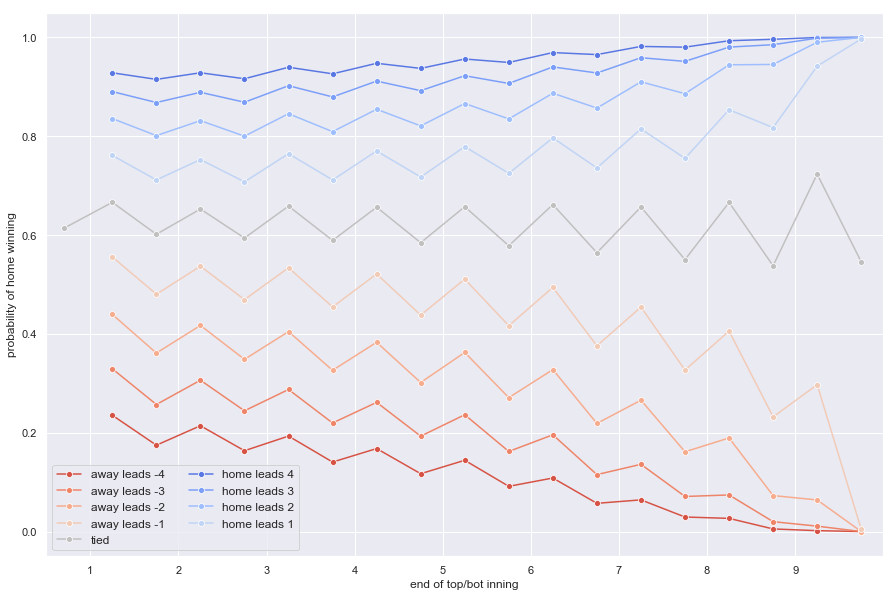

In [30]:
sns.set(style="darkgrid", palette="muted", color_codes=True, context='notebook')
p = sns.color_palette("coolwarm", 9)
f, axes = plt.subplots(1, 1, figsize=(15, 10))
for i in itertools.chain(range(-4, 1), range(4, 0, -1)):
    if i > 0:
        sns.lineplot(x=x_plot[:-4], y=y_plot[i][:-4], marker='o', label='home leads ' + str(i), color=p[4-i])
    elif i < 0:
        sns.lineplot(x=x_plot[:-4], y=y_plot[i][:-4], marker='o', label='away leads ' + str(i), color=p[4-i])
    else:
        pregame_home_win_prob = df_conference.groupby('game_info_url').last()['home_won'].mean()
        sns.lineplot(x=[0.7] + x_plot[:-4], y=[pregame_home_win_prob] + y_plot[i][:-4], marker='o', label='tied', color='silver')
    

plt.xlim(0.5, 10)
plt.ylim(-0.05, 1.05)
plt.xlabel('end of top/bot inning')
plt.ylabel('probability of home winning')
plt.xticks(np.arange(1, 10))
axes.legend(fontsize='medium', ncol=2)


Key observations
- When the home team is ahead, the win probability after the bottom of the 9th is 1. When the away team is ahead, the win probability after the bottom of the 9th is 0. This is good - that means we did not make a mistake in processing the data!
- The home field advantage starts at around 61%, which is much higher compared to MLB. Assuming the score remains tied, the home field advantage slowly decreases, until it is virtually 50% going into extra innings. This is supported by common baseball knowledge that the home field advantage is most significant in the first inning, because it affects the starting pitcher the most.
- Over time, any non-zero score differential becomes increasingly more difficult to overcome. Negative score differentials result in the win probability tending towards zero, and positive score differentials result in the win probability trending towards 1. 
- The larger the lead, the greater the win probability. The first run lead is most important, and each extra run results in a smaller increase in win probability.
- After the end of the top of an inning, the win probability goes up. This is because the home team has one extra half-inning to bat, so their win probability is increased simply by getting three outs in the top of that inning. At the end of the bottom of an inning, this difference is erased, since both teams have equal opportunities remaining to score. This explains the zig-zag shape. When the game is tied, the difference between each half-inning is greater, because any extra run scored in the additional scoring opportunities will likely be decisive.

### 4.5 Model Analysis

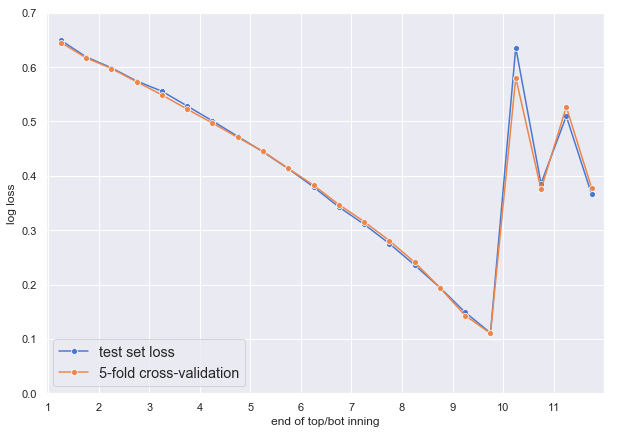

In [31]:
sns.set(style="darkgrid", palette="muted", color_codes=True, context='notebook')
f, axes = plt.subplots(1, 1, figsize=(10, 7))
sns.lineplot(x=x_plot, y=np.array(y_loss)[:, 0], marker='o', label='test set loss')
sns.lineplot(x=x_plot, y=-np.array(y_loss)[:, 1], marker='o', label='5-fold cross-validation')
plt.xlim(0.96, 12)
plt.xticks(np.arange(1, 12, 1))

plt.ylim(0, 0.7)
plt.xlabel('end of top/bot inning')
plt.ylabel('log loss')
axes.legend(fontsize='large')


The log loss starts at 0.65 and decreases with every half inning. This means our model is much better at predicting game outcomes given the score differential later in the game compared to the beginning, which makes sense. The cross-validation loss is almost identical to the test set loss, showing that our model does very well with out-of-sample examples. As shown in the table in 4.3, we used shuffling during cross-validation (typically done), but we also tried not shuffling to see if stratifying the folds by different time periods would reveal changes in the model over time in the 6 year's worth of data. The results are almost identical to cross-validation with shuffle, so that is not a problem.

Prediction for extra-inning games is difficult, as shown in the high log loss for our models after the 9th inning. Our model specification will not work, because the score differential at the end of the top half of an inning is always zero or negative. Also, for the bottom of an extra-inning game, a model should perfectly predict games whose score differential is non-zero, since the game ends, and will be a poor predictor when the score differential is zero. Since the range of possible score differentials during extra-innings is very small, perhaps we can simply use the mean prediction for each score differential.

Text(0, 0.5, 'probability of home winning')

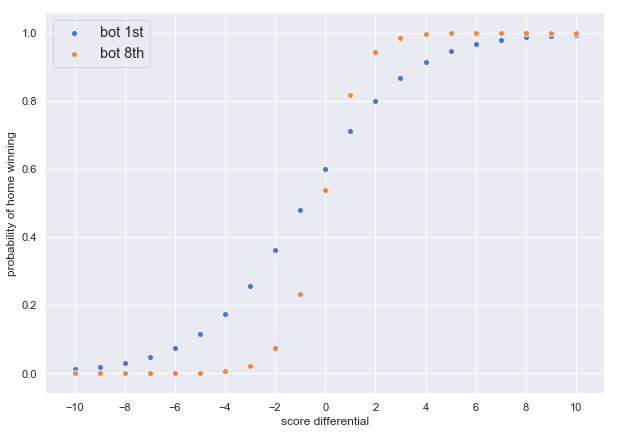

In [32]:
sns.set(style="darkgrid", palette="muted", color_codes=True, context='notebook')

f, ax = plt.subplots(figsize=(10, 7))
sns.despine(f, left=True, bottom=True)
result_preds = [y_plot[i][1] for i in range(-10, 11)]
result_preds2 = [y_plot[i][-7] for i in range(-10, 11)]

sns.scatterplot(x=np.arange(-10, 11), y=result_preds, label='bot 1st')
sns.scatterplot(x=np.arange(-10, 11), y=result_preds2, label='bot 8th')
ax.legend(fontsize='large')
ax.set_xticks(np.arange(-10, 11, 2))
plt.xlabel('score differential')
plt.ylabel('probability of home winning')

Here we show the logistic probability curve for two of our models. Both models are for probabilities at the end of an inning. Comparing the two curves, we see that the center of the blue curve is higher, showing the higher home field advantage at the beginning of the game. The yellow curve is steeper, since it is easier to hold a lead with only one inning remaining rather than eight. 

## 5. Creating an At-Bat Win Probability Model
As explained in the introduction, we to extend our model, which calculates the win probability at the end of a half-inning, so that we can calculate the win probability at any point during the inning.

### 5.1 Creating a Win Probability Table
First, we convert the run expectancy table from the introduction to a dictionary.

In [33]:
run_expectancy = pd.read_csv('run_expectancy_table.csv')

run_expectancy_table = {}
for index,row in run_expectancy.iterrows():
    run_expectancy_table[(row['base_1_occupied_pre'], row['base_2_occupied_pre'], row['base_3_occupied_pre'], 
                          row['outs_in_inning_so_far_before_event'])] = [row[str(i)] for i in range(6)]
run_expectancy

,base_1_occupied_pre,base_2_occupied_pre,base_3_occupied_pre,outs_in_inning_so_far_before_event,0,1,2,3,4,5,run_exp
0,False,False,False,0,0.694649,0.160238,0.075960,0.037348,0.017294,0.014510,0.565932
1,True,False,False,0,0.584801,0.200027,0.108036,0.056751,0.027155,0.023229,0.811120
2,False,True,False,0,0.521501,0.216880,0.127368,0.070083,0.034350,0.029818,0.968355
3,False,False,True,0,0.468239,0.226909,0.143826,0.082797,0.041582,0.036646,1.112513
4,True,True,False,0,0.402905,0.233117,0.163683,0.100589,0.052413,0.047293,1.308367
...,...,...,...,...,...,...,...,...,...,...,...
19,False,False,True,2,0.771010,0.126102,0.055093,0.026082,0.011863,0.009850,0.411237
20,True,True,False,2,0.720684,0.149136,0.068705,0.033327,0.015332,0.012816,0.511933
21,True,False,True,2,0.675812,0.167900,0.081297,0.040385,0.018793,0.015814,0.605891
22,False,True,True,2,0.617307,0.189540,0.098317,0.050560,0.023934,0.020343,0.735303


Next, we create a model for each half-inning, as we have done before. Since we are creating our final model and we are not evaluating this model any more, we can use the entire data set to train.

In [34]:
import itertools
models = {}
for inning, top_bot in itertools.product(range(1, 12), ['top', 'bot']):
    df_restricted = df_conference[(df_conference['inning'] == inning) & 
                          (df_conference['inning_top_bot'] == top_bot)]
    x = np.array([df_restricted['score_differential']]).T
    y = np.array(df_restricted['home_won']) 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0, shuffle=True, random_state=137)
    regressor = LogisticRegression()
    regressor.fit(x_train, y_train)
    models[(inning, top_bot)] = regressor

We can now define a function which calculates the win probability, by calculating the probabilities of various possible score differentials at the end of the inning, and multiplying by the win probabilities of those score differentials. Using the example in the introduction, say it’s the bottom of the 7th inning, the home team is winning by 1 run and has a runner on 1st with 2 outs. We can then calculate the probability of winning.

In [35]:
def win_probability(inning, top_or_bot, run_differential, b1, b2, b3, outs):
    state = (b1, b2, b3, outs)
    regressor = models[(inning, top_or_bot)]
    if top_or_bot == 'top':
        possible_scores = run_differential - np.arange(6) 
    else:
        possible_scores = run_differential + np.arange(6)
    a = regressor.predict_proba(possible_scores.reshape(-1, 1))[:, 1]
    b = run_expectancy_table[state]
    return np.dot(a, b)

win_probability(7, 'bot', 1, True, True, False, 2)

0.8035282020675496

Enumerating over all possible at-bat situations, we create an at-bat win probability model.

In [36]:
win_probability_table = []
for inning, top_bot, run_diff, b1, b2, b3, out in itertools.product( \
                        range(1, 10), ['top', 'bot'], \
                      range(-10, 11), [True, False], [True, False], [True, False], [0, 1, 2]):
    if inning == 9 and top_bot == 'bot' and run_diff > 0: # game can't reach this point
        continue
    if inning == 1 and top_bot == 'top' and run_diff > 0: # they haven't had an opportunity to score
        continue
    wp = win_probability(inning, top_bot, run_diff, b1, b2, b3, out)
    data = [inning, top_bot, run_diff, b1, b2, b3, out, wp]
    win_probability_table.append(data)
df_final = pd.DataFrame(win_probability_table, 
                        columns=['inning', 'inning_top_bot', 'score_differential', 
                                 'base_1_occupied_pre', 'base_2_occupied_pre', 'base_3_occupied_pre', 
                                 'outs_in_inning_so_far_before_event', 'win_probability'])

df_final.sample(n=10, random_state=100) # to show you a variety of scenarios and their win probabilities

,inning,inning_top_bot,score_differential,base_1_occupied_pre,base_2_occupied_pre,base_3_occupied_pre,outs_in_inning_so_far_before_event,win_probability
2485,3,bot,-2,False,True,True,1,0.469727
6910,8,top,-7,False,False,False,1,0.000928
7538,8,bot,-1,True,True,True,2,0.490235
2652,3,bot,5,False,True,True,0,0.975098
4259,5,top,9,True,False,False,2,0.996810
6421,7,bot,-6,False,True,True,1,0.034966
7120,8,top,2,False,True,False,1,0.859346
8558,9,bot,-1,False,True,True,2,0.298557
435,1,bot,-3,True,True,False,0,0.404282
4443,5,bot,-4,True,True,False,0,0.223093


Lastly, we save this table into a csv file so it can be used to perform other in-game analysis.

In [37]:
df_final.to_csv(path_or_buf='win_probability_table.csv', header=True, index=False)

### 5.2 Case Study: UCLA vs. Stanford, 04/15/2017
Let's look at a case study to see how the win probability model can help us analyze the impact of various plays in a game. We've chosen a case study that involves both teams taking the lead multiple times, and ends in extra innings in an exciting manner.

We begin by reading an annotated csv of the game (which has the bases occupied and outs before each play labeled), looking up the win probability before each play as well as after each play, and then calculating the change in win probability each play had on the game. 

We had a dummy row at the end of the game to signify the result. This will allow us to calculate the probability change of the last play.

Actual game listed here:
https://stats.ncaa.org/game/index/4353130?org_...

See the appendix for the full game and win probability calculation.

In [44]:
df = pd.read_csv('case_analysis.csv')

arr = []
for index, row in df.iterrows():
    inning = row['inning']
    top_bot = row['inning_top_bot']
    run_diff = row['score_differential_pre']
    b1 = row['base_1_occupied_pre']
    b2 = row['base_2_occupied_pre']
    b3 = row['base_3_occupied_pre']
    out = row['outs_in_inning_so_far_before_event']
    arr.append(win_probability(inning, top_bot, run_diff, b1, b2, b3, out))

df['win_probability_pre'] = arr
df['win_probability_post'] = np.array(arr + [0])[1:]
df['win_probability_change'] = df['win_probability_post'] - df['win_probability_pre']
df = df.append({'plot_x':11, 'win_probability_pre':0}, ignore_index=True)

pd.set_option('display.max_rows', 10)
df.drop(['plot_x', 'game_info_url', 'score_differential'], axis=1)

,inning,inning_top_bot,description,home_team,away_team,away_score,home_score,score_differential_pre,base_1_occupied_pre,base_2_occupied_pre,base_3_occupied_pre,outs_in_inning_so_far_before_event,win_probability_pre,win_probability_post,win_probability_change
0,1.0,top,Amaral flied out to lf (0-1 K).,Stanford,UCLA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.604783,0.630444,0.025661
1,1.0,top,Hirabayashi grounded out to 3b (1-2 SKB).,Stanford,UCLA,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.630444,0.646059,0.015615
2,1.0,top,Bouchard singled through the left side (1-0 B).,Stanford,UCLA,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.646059,0.635777,-0.010282
3,1.0,top,Pries grounded out to 1b unassisted (0-1 K).,Stanford,UCLA,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.635777,0.654750,0.018973
4,1.0,bot,"Winaker, M. popped up to ss (1-1 FB).",Stanford,UCLA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.654750,0.632565,-0.022184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,10.0,bot,"Kinamon, D. grounded out to p, SAC, bunt (0-0); Molfetta, C. advanced to second.",Stanford,UCLA,7.0,6.0,-1.0,1.0,0.0,0.0,0.0,0.329076,0.250484,-0.078592
94,10.0,bot,"Molfetta, C. advanced to third on a wild pitch.",Stanford,UCLA,7.0,6.0,-1.0,0.0,1.0,0.0,1.0,0.250484,0.289332,0.038847
95,10.0,bot,"Winaker, M. lined out to ss (2-0 BB).",Stanford,UCLA,7.0,6.0,-1.0,0.0,0.0,1.0,1.0,0.289332,0.179931,-0.109401
96,10.0,bot,"Hoerner, N. grounded out to ss (2-1 KBB).",Stanford,UCLA,7.0,6.0,-1.0,0.0,0.0,1.0,2.0,0.179931,0.000000,-0.179931


This allows us to list the most impactful at-bats of the game. The at-bats which shifted the win probability by more than 15% is listed in the table below. While the table includes many of the scoring plays, the critical outs of the game (particularly at the later innings) are also listed.

In [39]:
pd.set_option('display.max_rows', 15)
df[abs(df['win_probability_change']) > 0.10].drop(['plot_x', 'game_info_url', 'score_differential'], axis=1)

,inning,inning_top_bot,description,home_team,away_team,away_score,home_score,score_differential_pre,base_1_occupied_pre,base_2_occupied_pre,base_3_occupied_pre,outs_in_inning_so_far_before_event,win_probability_pre,win_probability_post,win_probability_change
8,2.0,top,"Clarke homered to right center, RBI (0-0).",Stanford,UCLA,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.615480,0.501243,-0.114238
27,4.0,top,"Toglia singled through the left side, advanced to second on the throw, RBI (1-2 KBS); Clarke scored.",Stanford,UCLA,2.0,0.0,-1.0,0.0,1.0,0.0,2.0,0.475968,0.345721,-0.130246
45,6.0,top,"Toglia homered to left field, 2 RBI (0-1 K); Strumpf scored.",Stanford,UCLA,4.0,0.0,-2.0,1.0,0.0,0.0,1.0,0.273182,0.093654,-0.179528
63,7.0,bot,"Bakst, Dan doubled to right center, RBI (0-0); Brodey, Q. scored.",Stanford,UCLA,4.0,3.0,-2.0,1.0,0.0,0.0,2.0,0.209913,0.393576,0.183663
65,7.0,bot,"Klein, J. popped up to cf (2-2 BKFBF).",Stanford,UCLA,4.0,3.0,-1.0,1.0,0.0,1.0,2.0,0.443657,0.319815,-0.123842
67,8.0,top,"Strumpf homered to left field, RBI (2-0 BB).",Stanford,UCLA,5.0,3.0,-1.0,0.0,0.0,0.0,1.0,0.355668,0.163894,-0.191774
73,8.0,bot,"Winaker, M. homered to right field, 3 RBI (2-0 BB); Kinamon, D. scored; Handley, M. scored.",Stanford,UCLA,5.0,6.0,-2.0,1.0,1.0,0.0,1.0,0.254885,0.846373,0.591488
80,9.0,top,"Cuellar doubled to left center, RBI (2-2 BKFB); Godin scored.",Stanford,UCLA,6.0,6.0,1.0,0.0,0.0,1.0,2.0,0.833705,0.618765,-0.214940
82,9.0,top,Pries lined out to rf (1-0 B).,Stanford,UCLA,6.0,6.0,0.0,1.0,1.0,0.0,2.0,0.570885,0.683918,0.113033
88,10.0,top,"Toglia singled through the left side, advanced to second on the throw, RBI (1-2 BKKF); Stephens scored.",Stanford,UCLA,7.0,6.0,0.0,0.0,1.0,0.0,1.0,0.509206,0.214324,-0.294882


Lastly, we can plot the win probabilities over the course of the game.

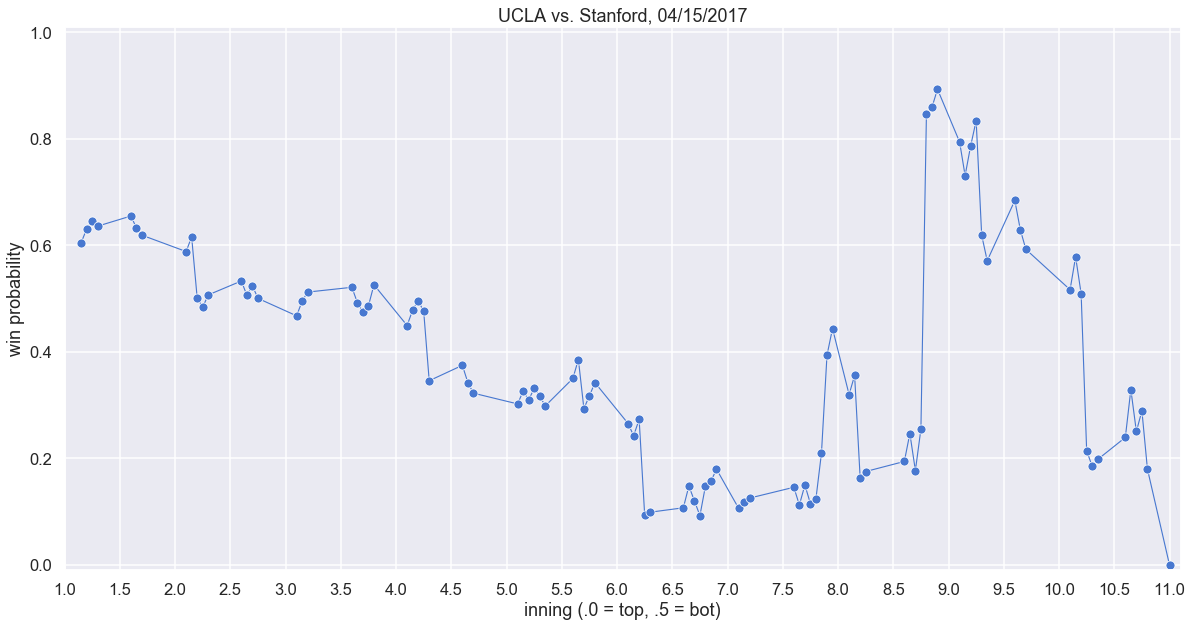

In [40]:
sns.set(style="darkgrid", palette="muted", color_codes=True, context='talk')

f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x='plot_x', y='win_probability_pre', marker='o', size=10, data=df, ax=ax)
ax.set_xticks(np.arange(1, 11.5, 0.5))
ax.set_xlim(1, 11.1)
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel('inning (.0 = top, .5 = bot)')
ax.set_ylabel('win probability')
ax.set_title('UCLA vs. Stanford, 04/15/2017')

ax.get_legend().remove()

## 5. Next Steps
Here are some ideas to improve the model:
- Incorporate a feature that normalizes the score differential by the run enviornment. 
- Create a separate model based on the day of the week and/or the conference.
- Use a different model for the top of the first, and top of the ninth. At the top of the first the run differential cannot be positive, while at the top of the ninth the home team wins games whose run differential is greater than 0.
- Use a Markov chain to model tied games at the top of the 9th, all the way into the extra innings. Since we have very few states (score differential = 0, -1, -2, -3, ..., up to a reasonable upper limit like -6), we can easily estimate the probability of transitions to these states (using the run expectancy table) and the conditional probability of winning given a score_differential at the end of the top half. The advantage is that if we assume that the start of each extra inning is identical (so inning 11 is the same as inning 19), we have significantly more data to estimate the transition probabilities. In addition, since we have the end result of each, we can validate these models.

## 6. Appendix: Case Study Full Game

In [46]:
pd.set_option('display.max_rows', 1000)
df.drop(['plot_x', 'game_info_url', 'score_differential'], axis=1)

,inning,inning_top_bot,description,home_team,away_team,away_score,home_score,score_differential_pre,base_1_occupied_pre,base_2_occupied_pre,base_3_occupied_pre,outs_in_inning_so_far_before_event,win_probability_pre,win_probability_post,win_probability_change
0,1.0,top,Amaral flied out to lf (0-1 K).,Stanford,UCLA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.604783,0.630444,0.025661
1,1.0,top,Hirabayashi grounded out to 3b (1-2 SKB).,Stanford,UCLA,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.630444,0.646059,0.015615
2,1.0,top,Bouchard singled through the left side (1-0 B).,Stanford,UCLA,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.646059,0.635777,-0.010282
3,1.0,top,Pries grounded out to 1b unassisted (0-1 K).,Stanford,UCLA,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.635777,0.654750,0.018973
4,1.0,bot,"Winaker, M. popped up to ss (1-1 FB).",Stanford,UCLA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.654750,0.632565,-0.022184
5,1.0,bot,"Hoerner, N. lined out to 3b (1-2 KFB).",Stanford,UCLA,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.632565,0.618819,-0.013746
6,1.0,bot,"Brodey, Q. struck out looking (2-2 BBSFK).",Stanford,UCLA,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.618819,0.588131,-0.030688
7,2.0,top,Strumpf grounded out to ss (3-1 BBBK).,Stanford,UCLA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.588131,0.615480,0.027349
8,2.0,top,"Clarke homered to right center, RBI (0-0).",Stanford,UCLA,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.615480,0.501243,-0.114238
9,2.0,top,Toglia hit by pitch (1-2 KBK).,Stanford,UCLA,1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.501243,0.483709,-0.017534
